## Datasets

In [95]:
# !rm -r saved_model
# !rm tweet_classification_models.tar.gz

In [ ]:
## Datasets
## 1. Twitter sentiment extraction Kaggle dataset (27k): https://www.kaggle.com/competitions/tweet-sentiment-extraction/overview
## 2. Imdb dataset (25k training and 25k testing): http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
## 3. Sentiment140 (1.4M): http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
## 4. Sandars: https://github.com/zfz/twitter_corpus/blob/09afbfb5b580c848062aadbc4491fecc96b0a85a/full-corpus.csv

## Importing libraries and tools

In [48]:
!pip install emoji
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import csv
import os
import sys
import pickle
import subprocess

from sklearn.utils import shuffle

import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

# import spacy
import emoji
import contractions

In [97]:
## Versions
print('Python version:', sys.version)
print('NumPy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('TensorFlow version:', tf.__version__)

Python version: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
NumPy version: 1.22.4
Pandas version: 1.5.3
TensorFlow version: 2.12.0


In [ ]:
from google.colab import files
file = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


## Utility functions

In [98]:
# import pandas as pd
# import numpy as np
# import csv

# from sklearn.utils import shuffle

def clean_sentences(sentences):
    # preprocessing
    # 1. Removing links
    pattern = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    sentences = [re.sub(pattern, r' ', tweet) for tweet in sentences]
    # 2. Removing numbers
    sentences = [re.sub(r'\d+', r'', tweet) for tweet in sentences]
    # 3. Replacing hastags and emojis with words and removing punctuation
    sentences = [re.sub(r'[_:.]', r' ', emoji.demojize(re.sub(r'#(\w+)\b', r'\1', sentence))) for sentence in sentences]
    sentences = [re.sub(r'[^\w\s]', '', tweet) for tweet in sentences]
    # 4. Removing handles
    sentences = [re.sub(r'@[a-z0-9_]{1,15}', r'', tweet) for tweet in sentences]
    # 5. lowercasing 
    sentences = [sentence.lower() for sentence in sentences]
    # 6. Contracting elongated words
    sentences = [re.sub(r'(.)\1{2,}', r'\1', tweet) for tweet in sentences]
    # 7. Expanding contractions
    sentences = [contractions.fix(tweet) for tweet in sentences]
    # 8. Removing all extra spaces
    sentences = [' '.join(tweet.split()) for tweet in sentences]
    return sentences

# filepath = 'train.csv'
def pre_processing(filepath, split_size=None, num_classes=2, training_data=True, random_state=0, selected_text=False):
    """
    Returns the training and validation data lists from the input csv path if training_data is True.
    Else it returns testing data from the filepath. 

    This function is specific to the Twitter Sentiment extraction Kaggle dataset.
    Link to data: https://www.kaggle.com/competitions/tweet-sentiment-extraction/overview

    Parameters:
        filepath (string): path to the data
        split_size (float): train and test data ratio
        num_classes (int): number of classes in the output labels
        random_state (int): random_state for sklearn.shuffle
        selected_text (bool): choosing selected text or total text from the train data

    Returns:
        if split_size is not None:
        train_sentences (list): A list of strings for training
        train_labels (list): A list of integers representing different classes for training
        validation_sentences (list): A list of strings for validation
        validation_labels (list): A list of integers representing different classes for validation

        if split_size is None:
        sentences (list): A list of strings
        labels (list): A list of integers representing different classes
    """

    assert num_classes == 3 or num_classes == 2, "num_classes takes only integer values of 2 or 3"

    if training_data == True:
        label_col, text_col = 3, 1
    else:
        label_col, text_col = 2, 1

    sentences = []
    labels = [] 
    with open(filepath) as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            if len(row[text_col]) <= 0: # Min number of characters
                continue
            # Appending classes: positive:1, negative:0, neutral:2
            if num_classes == 3:
                labels.append(0 if row[label_col]=='negative' else 1 if row[label_col]=='positive' else 2)
            elif num_classes == 2:
                if row[label_col] == 'neutral': continue
                labels.append(0 if row[label_col]=='negative' else 1)
            else:
                raise ValueError("num_classes takes only integer values of 2 or 3")

            sentences.append(row[text_col])

    # shuffling the data
    sentences, labels = shuffle(sentences, labels, random_state=random_state)

    sentences = clean_sentences(sentences)
    
    if split_size is not None:
        train_size = int(len(sentences) * split_size)

        # splitting the data
        train_sentences = sentences[:train_size]
        train_labels = labels[:train_size]

        validation_sentences = sentences[train_size:]
        validation_labels = labels[train_size:]

        assert len(np.unique(train_labels)) == len(np.unique(validation_labels)), "Training or Validation sets have missing labels. Try a different random_state."
        
        return train_sentences, train_labels, validation_sentences, validation_labels
    
    else:
        return sentences, labels

# Plot Utility
def plot_graphs(history, string):
    """Plots the train or validation losses and accuracies for each epoch."""
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'validation '+string])
    plt.title(f'{string.title()} vs Epoch')
    plt.show()


## Saving entire model
def save_model_tokenizer(model, tokenizer, name_tag='my', folder='saved_model'):
    subprocess.run("mkdir -p saved_model".split())
    
    # Saving tokenizer
    with open('{}/{}_tokenizer.pickle'.format(folder, name_tag), 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Saving model
    model.save(os.path.join(folder, '{}_model'.format(name_tag)))

def text_preprocessing(sentences):
    # 1. Hastags to words, Emojis to text, replace '_', ':' and '.' with space ' '
    cleaned_sentences = [re.sub(r'[_:.]', r' ', emoji.demojize(re.sub(r'#(\w+)\b', r'\1', sentence))) for sentence in sentences]
    # # 2. Removing stop words
    # en = spacy.load('en_core_web_sm')
    # sw_spacy = en.Defaults.stop_words
    # cleaned_sentences = [' '.join([word for word in sentence.split() if word not in sw_spacy]) for sentence in cleaned_sentences]
    return cleaned_sentences

def transform_tweets(tweets, tokenizer, max_length=35):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences,maxlen=max_length)
    return padded


class TSAClassifier:
    def __init__(self, model_path, tokenizer_path, max_length=35, print_summary=False):
        self.model = tf.keras.models.load_model(model_path)
        with open(tokenizer_path, 'rb') as handle:
            self.tokenizer = pickle.load(handle)
        if print_summary == True:
            self.model.summary()
        self.max_length = max_length
    
    def predict(self, input_sentences, round_results=True):
        input_sentences = self.clean_sentences(input_sentences)
        sequences = self.tokenizer.texts_to_sequences(input_sentences)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length)
        if round_results:
                return np.round(self.model.predict(padded_sequences))#.tolist()
        return self.model.predict(padded_sequences)#.tolist()
    
    @staticmethod
    def clean_sentences(sentences):
        # preprocessing
        # 1. Removing links
        pattern = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
        sentences = [re.sub(pattern, r' ', tweet) for tweet in sentences]
        # 2. Removing numbers
        sentences = [re.sub(r'\d+', r'', tweet) for tweet in sentences]
        # 3. Replacing hastags and emojis with words and removing punctuation
        sentences = [re.sub(r'[_:.]', r' ', emoji.demojize(re.sub(r'#(\w+)\b', r'\1', sentence))) for sentence in sentences]
        sentences = [re.sub(r'[^\w\s]', '', tweet) for tweet in sentences]
        # 4. Removing handles
        sentences = [re.sub(r'@[a-z0-9_]{1,15}', r'', tweet) for tweet in sentences]
        # 5. lowercasing 
        sentences = [sentence.lower() for sentence in sentences]
        # 6. Contracting elongated words
        sentences = [re.sub(r'(.)\1{2,}', r'\1', tweet) for tweet in sentences]
        # 7. Expanding contractions
        sentences = [contractions.fix(tweet) for tweet in sentences]
        # 8. Removing all extra spaces
        sentences = [' '.join(tweet.split()) for tweet in sentences]
        return sentences


In [99]:
text = 'soooo hiiiii whyyyy done @elonmusk 3934 #hello I\'ve worked sooo hard! Gfg, is_ best : for ! Geeks ;'
clean_sentences([text])

['so hi why done elonmusk hello i have worked so hard gfg is best for geeks']

## Modeling: Twitter data

### Preparing Data

In [100]:
# import tensorflow as tf 
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [101]:
# Global Parameters
vocab_size = 10000
max_length = 35
oov_token = '<OOV>'
trunc_type = 'post'
padding_type = 'post'

In [102]:
filepath = 'train.csv'
train_sentences, train_labels, validation_sentences, validation_labels = pre_processing(filepath, split_size=0.9, training_data=True)
filepath = 'test.csv'
test_sentences, test_labels = pre_processing(filepath, training_data=False)

print('Training examples:', len(train_sentences))
print('\tPositive examples:', sum([1 for label in train_labels if label == 1 ]))
print('\tNegative examples:', sum([1 for label in train_labels if label == 0 ]))
print('Validation examples:', len(validation_sentences))
print('\tPositive examples:', sum([1 for label in validation_labels if label == 1 ]))
print('\tNegative examples:', sum([1 for label in validation_labels if label == 0 ]))
print('Test examples:', len(test_sentences))
print('\tPositive examples:', sum([1 for label in test_labels if label == 1 ]))
print('\tNegative examples:', sum([1 for label in test_labels if label == 0 ]))

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
index_word = tokenizer.index_word
print('Corpus size:', len(word_index))

# Tokenizing training data
num_classes = 2
train_sequences = tokenizer.texts_to_sequences(train_sentences)
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# train_labels = tf.keras.utils.to_categorical(np.array(train_labels), num_classes=num_classes, dtype='float32')

# Tokenizing validation data
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
padded_validation_sequences = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# validation_labels = tf.keras.utils.to_categorical(np.array(validation_labels), num_classes=num_classes, dtype='float32')

# Tokenizing test data
test_sequences = tokenizer.texts_to_sequences(test_sentences)
padded_test_sequences = pad_sequences(test_sequences,  maxlen=max_length, padding=padding_type, truncating=trunc_type)
# test_labels = tf.keras.utils.to_categorical(np.array(test_labels), num_classes=num_classes, dtype='float32')


Training examples: 14726
	Positive examples: 7737
	Negative examples: 6989
Validation examples: 1637
	Positive examples: 845
	Negative examples: 792
Test examples: 2104
	Positive examples: 1103
	Negative examples: 1001
Corpus size: 16100


In [103]:
import csv
with open('sentiment_train_data.csv', 'w') as f:
    writer = csv.writer(f)
    for text, label in zip(train_sentences, train_labels):
        writer.writerow([text, label])

with open('sentiment_validation_data.csv', 'w') as f:
    writer = csv.writer(f)
    for text, label in zip(validation_sentences, validation_labels):
        writer.writerow([text, label])

In [104]:
train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)
test_labels = np.array(test_labels)

### Downloading Twitter GloVe Embeddings

In [ ]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip

--2023-05-04 11:36:01--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2023-05-04 11:36:01--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z  99%[==================> ]   1.41G  5.07MB/s    eta 1s     

In [ ]:
!unzip -q glove.twitter.27B.zip

In [ ]:
!du .

In [105]:
glove_embeddings = ['glove.twitter.27B.25d.txt',
                    'glove.twitter.27B.50d.txt',
                    'glove.twitter.27B.100d.txt',
                    'glove.twitter.27B.200d.txt',
                    ]

embedding_dim = 200
index = 0
for i, filename in enumerate(glove_embeddings):
    if str(embedding_dim) in filename:
        index = i

filepath = glove_embeddings[i]

embeddings_index = {}
with open(filepath) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

In [106]:
len(embeddings_index)

1193514

### Creating the Embedding matrix

In [108]:
# vocab_size = 10000
# embedding_dim = 50 * 4 # variable exists at code where we load embeddings
num_tokens = vocab_size + 1

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for index in range(2, num_tokens):
    word = index_word[index]
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Model 4.1: LSTM-CNN Model (GloVe, two classes)

In [109]:
def model_four():
    # Parameters
    lstm_dim = 32
    dense_dim = 24
    conv_filters = 64
    dropout_rate = 0.6

    # Model Definition with LSTM
    model_lstm_conv = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_tokens, embedding_dim, input_length=max_length, 
                                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True)),
        tf.keras.layers.Dropout(dropout_rate),
        # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
        # tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Conv1D(conv_filters, 5),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    # Set the training parameters
    model_lstm_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print the model summary
    model_lstm_conv.summary()

    NUM_EPOCHS = 15

    # Train the model
    print('\nTRAINING MODEL:')
    history_lstm_conv = model_lstm_conv.fit(padded_train_sequences, train_labels, epochs=NUM_EPOCHS, validation_data=(padded_validation_sequences, validation_labels))


    # Evaluating on test data
    print('\nEVALUATING MODEL ON TEST DATA:')
    model_lstm_conv.evaluate(padded_test_sequences, test_labels)

    return history_lstm_conv, model_lstm_conv

history, model = model_four()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 35, 200)           2000200   
                                                                 
 bidirectional_5 (Bidirectio  (None, 35, 64)           59648     
 nal)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 35, 64)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 31, 64)            20544     
                                                                 
 global_average_pooling1d_5   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 re_lu_5 (ReLU)              (None, 64)               

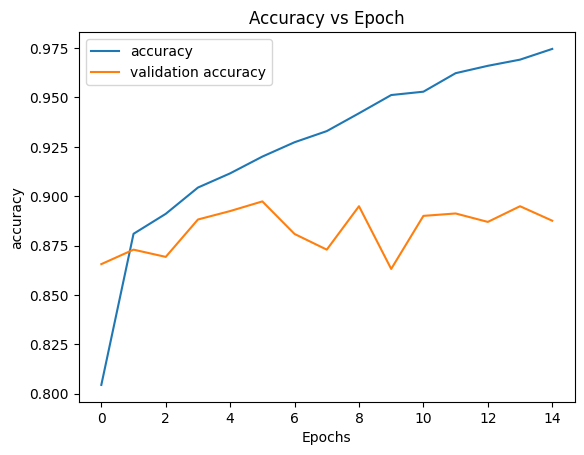

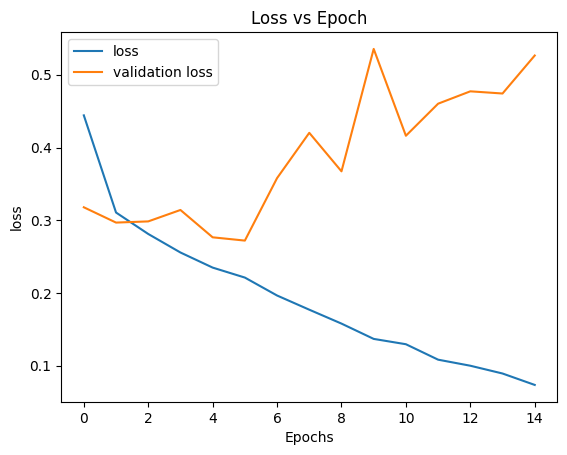

In [110]:
# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [112]:
# from tensorflow.keras.utils import plot_model
# import pydot
# plot_model(model, show_shapes=True, show_layer_names=True, to_file='sentiment_model.png')

In [113]:
save_model_tokenizer(model, tokenizer, name_tag='sentiment')

## Sarcasm Detection

### Preparing Data

In [114]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2023-05-04 15:40:05--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2023-05-04 15:40:05 (172 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [115]:
import json

# Load the JSON file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

np.random.seed(0)
# Collect sentences and labels into the lists
for item in datastore:
    if item['is_sarcastic'] == 1 and np.random.choice([0, 1], p=[0.8, 0.2]):
        sentences.append(item['headline'])
        labels.append(item['is_sarcastic'])
    elif item['is_sarcastic'] == 0: 
        sentences.append(item['headline'])
        labels.append(item['is_sarcastic'])

sentences = clean_sentences(sentences)
print('Dataset size:', len(sentences))


Dataset size: 17290


In [116]:
training_size = int(len(sentences)*0.9)

# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [117]:
train_labels = training_labels
validation_labels = testing_labels
train_sentences = training_sentences
validation_sentences = testing_sentences
print('Training examples:', len(train_sentences))
print('\tPositive examples:', sum([1 for label in train_labels if label == 1 ]))
print('\tNegative examples:', sum([1 for label in train_labels if label == 0 ]))
print('Validation examples:', len(validation_sentences))
print('\tPositive examples:', sum([1 for label in validation_labels if label == 1 ]))
print('\tNegative examples:', sum([1 for label in validation_labels if label == 0 ]))
# print('Test examples:', len(test_sentences))
# print('\tPositive examples:', sum([1 for label in test_labels if label == 1 ]))
# print('\tNegative examples:', sum([1 for label in test_labels if label == 0 ]))

Training examples: 15561
	Positive examples: 2092
	Negative examples: 13469
Validation examples: 1729
	Positive examples: 213
	Negative examples: 1516


In [118]:
training_data = []
for headline, label in zip(training_sentences, training_labels):
    training_data.append({'headline': headline, 'is_sarcastic': label})
with open('sarcasm_training_data.json', 'w') as f:
    json.dump(training_data, f)

In [119]:
validation_data = []
for headline, label in zip(testing_sentences, testing_labels):
    validation_data.append({'headline': headline, 'is_sarcastic': label})
with open('sarcasm_validation_data.json', 'w') as f:
    json.dump(validation_data, f)

### Pre-processing

In [120]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 35
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
index_word = tokenizer.index_word

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

### Creating the Embedding matrix

In [121]:
# vocab_size = 10000
# embedding_dim = 50 # variable exists at code where we load embeddings
print('Embedding dimension:', embedding_dim)
num_tokens = vocab_size + 1

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for index in range(2, num_tokens):
    word = index_word[index]
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Embedding dimension: 200


### Model 2.1 LSTM-CNN Model (GloVe)

In [122]:
def model_four():
    # Parameters
    lstm_dim = 32
    dense_dim = 24
    conv_filters = 64
    dropout_rate = 0.6

    # Model Definition with LSTM
    model_lstm_conv = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_tokens, embedding_dim, input_length=max_length, 
                                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True)),
        tf.keras.layers.Dropout(dropout_rate),
        # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
        # tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Conv1D(conv_filters, 5),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    # Set the training parameters
    # model_lstm_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_lstm_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    # Print the model summary
    model_lstm_conv.summary()

    NUM_EPOCHS = 6

    # Train the model
    print('\nTRAINING MODEL:')
    # history_lstm_conv = model_lstm_conv.fit(padded_train_sequences, train_labels, epochs=NUM_EPOCHS, validation_data=(padded_validation_sequences, validation_labels))
    history_lstm_conv = model_lstm_conv.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels))

    return history_lstm_conv, model_lstm_conv

history, model = model_four()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 35, 200)           2000200   
                                                                 
 bidirectional_6 (Bidirectio  (None, 35, 64)           59648     
 nal)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 35, 64)            0         
                                                                 
 conv1d_6 (Conv1D)           (None, 31, 64)            20544     
                                                                 
 global_average_pooling1d_6   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 re_lu_6 (ReLU)              (None, 64)               

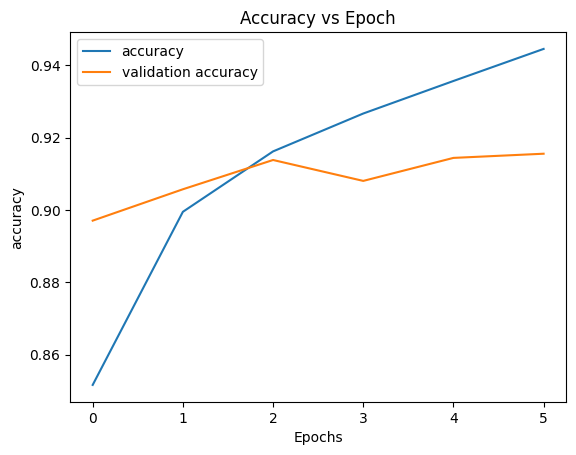

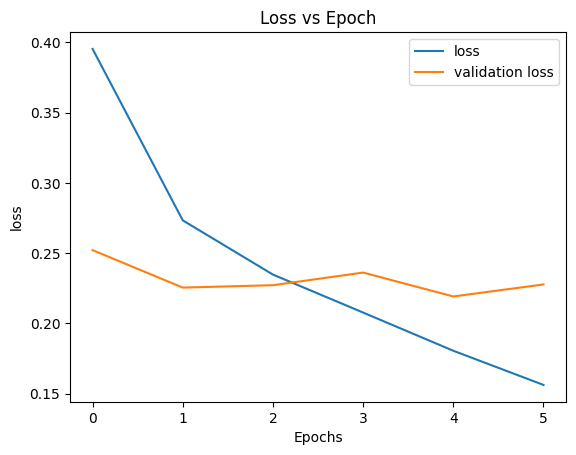

In [123]:
# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [124]:
save_model_tokenizer(model, tokenizer, name_tag='sarcasm')

In [ ]:
# model.save_weights('./checkpoints/my_checkpoint')

In [125]:
# !zip -r /content/tweet_classification_models.zip /content/saved_model
!tar -czvf /content/tweet_classification_models.tar.gz /content/saved_model

from google.colab import files
files.download("/content/tweet_classification_models.tar.gz")

tar: Removing leading `/' from member names
/content/saved_model/
/content/saved_model/sarcasm_tokenizer.pickle
/content/saved_model/sarcasm_model/
/content/saved_model/sarcasm_model/variables/
/content/saved_model/sarcasm_model/variables/variables.data-00000-of-00001
/content/saved_model/sarcasm_model/variables/variables.index
/content/saved_model/sarcasm_model/saved_model.pb
/content/saved_model/sarcasm_model/assets/
/content/saved_model/sarcasm_model/fingerprint.pb
/content/saved_model/sarcasm_model/keras_metadata.pb
/content/saved_model/sentiment_tokenizer.pickle
/content/saved_model/sentiment_model/
/content/saved_model/sentiment_model/variables/
/content/saved_model/sentiment_model/variables/variables.data-00000-of-00001
/content/saved_model/sentiment_model/variables/variables.index
/content/saved_model/sentiment_model/saved_model.pb
/content/saved_model/sentiment_model/assets/
/content/saved_model/sentiment_model/fingerprint.pb
/content/saved_model/sentiment_model/keras_metadata

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [139]:
!tar -czvf /content/all_data.tar.gz /content/sentiment_train_data.csv\
/content/sentiment_validation_data.csv\
/content/sarcasm_training_data.json\
/content/sarcasm_validation_data.json

files.download("/content/all_data.tar.gz")

tar: Removing leading `/' from member names
/content/sentiment_train_data.csv
tar: Removing leading `/' from hard link targets
/content/sentiment_validation_data.csv
/content/sarcasm_training_data.json
/content/sarcasm_validation_data.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [127]:
!du saved_model

8796	saved_model/sarcasm_model/variables
4	saved_model/sarcasm_model/assets
132268	saved_model/sarcasm_model
8796	saved_model/sentiment_model/variables
4	saved_model/sentiment_model/assets
127988	saved_model/sentiment_model
261660	saved_model


## Combined Model performance 

In [ ]:
# Note: Make sure the paths to the model and Sentiment data are correct below in the 'load_model' function
# and 'filepath' variables

In [128]:
import emoji
# import snscrape.modules.twitter as sntwitter

import os
import sys
import re
import pickle
import json

import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [129]:
class TSAClassifier:
    def __init__(self, model_path, tokenizer_path, max_length=35, print_summary=False):
        self.model = tf.keras.models.load_model(model_path)
        with open(tokenizer_path, 'rb') as handle:
            self.tokenizer = pickle.load(handle)
        if print_summary == True:
            self.model.summary()
        self.max_length = max_length
    
    def predict(self, input_sentences, round_results=True):
        input_sentences = self.clean_sentences(input_sentences)
        sequences = self.tokenizer.texts_to_sequences(input_sentences)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length)
        if round_results:
                return np.round(self.model.predict(padded_sequences))#.tolist()
        return self.model.predict(padded_sequences)#.tolist()
    
    @staticmethod
    def clean_sentences(sentences):
        # preprocessing
        # 1. Removing links
        pattern = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
        sentences = [re.sub(pattern, r' ', tweet) for tweet in sentences]
        # 2. Removing numbers
        sentences = [re.sub(r'\d+', r'', tweet) for tweet in sentences]
        # 3. Replacing hastags and emojis with words and removing punctuation
        sentences = [re.sub(r'[_:.]', r' ', emoji.demojize(re.sub(r'#(\w+)\b', r'\1', sentence))) for sentence in sentences]
        sentences = [re.sub(r'[^\w\s]', '', tweet) for tweet in sentences]
        # 4. Removing handles
        sentences = [re.sub(r'@[a-z0-9_]{1,15}', r'', tweet) for tweet in sentences]
        # 5. lowercasing 
        sentences = [sentence.lower() for sentence in sentences]
        # 6. Contracting elongated words
        sentences = [re.sub(r'(.)\1{2,}', r'\1', tweet) for tweet in sentences]
        # 7. Expanding contractions
        sentences = [contractions.fix(tweet) for tweet in sentences]
        # 8. Removing all extra spaces
        sentences = [' '.join(tweet.split()) for tweet in sentences]
        return sentences

def load_model():
    model_path = os.path.join(os.getcwd(), 'saved_model', 'sentiment_model')
    tokenizer_path = os.path.join(os.getcwd(), 'saved_model', 'sentiment_tokenizer.pickle')

    sentiment_model = TSAClassifier(model_path, tokenizer_path, max_length=35)

    model_path = os.path.join(os.getcwd(), 'saved_model', 'sarcasm_model')
    tokenizer_path = os.path.join(os.getcwd(), 'saved_model', 'sarcasm_tokenizer.pickle')

    sarcasm_model = TSAClassifier(model_path, tokenizer_path, max_length=35)

    return sentiment_model, sarcasm_model


def load_sentiment_data(filepath):
    sentences = []
    labels = [] 
    with open(filepath) as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            labels.append(int(row[1]))
            sentences.append(row[0])

    sentences = clean_sentences(sentences)

    return sentences, labels

def load_sarcasm_data(filepath):
    with open(filepath, 'r') as f:
        datastore = json.load(f)

    # Initialize the lists
    sentences = []
    labels = []

    # Collect sentences and labels into the lists
    for item in datastore:
        sentences.append(item['headline'])
        labels.append(int(item['is_sarcastic']))

    sentences = clean_sentences(sentences)

    return sentences, labels

In [130]:
sentiment_model, sarcasm_model = load_model()

In [131]:
# Loading Sentiment data (saved train and validation data)
filepath = 'sentiment_train_data.csv'
train_sentences, train_labels = load_sentiment_data(filepath)
filepath = 'sentiment_validation_data.csv'
validation_sentences, validation_labels = load_sentiment_data(filepath)

In [132]:
# Checking examples
index = 4
print(validation_sentences[index])
print(validation_labels[index], type(validation_labels[index]))

stellar you look great
1 <class 'int'>


In [133]:
# # Loading Sarcasm data (saved train and validation data)
# filepath = 'sarcasm_training_data.json'
# train_sentences, train_labels = load_sarcasm_data(filepath)
# filepath = 'sarcasm_validation_data.json'
# validation_sentences, validation_labels = load_sarcasm_data(filepath)

In [134]:
# Use this to check accuracy on validation set of Sentiment data. You can change
# variables to check for appropriate data you need from above cells.
tweet_list = validation_sentences
tweet_labels = validation_labels


sentiment_preds = np.squeeze(sentiment_model.predict(tweet_list, round_results=True))
sarcasm_preds = np.squeeze(sarcasm_model.predict(tweet_list, round_results=True))

if sentiment_preds.shape == ():
    sentiment_preds, sarcasm_preds = [int(sentiment_preds)], [int(sarcasm_preds)]
    # combined_preds = sentiment_preds ^ sarcasm_preds
combined_preds = np.array([int(i)^int(j) for i, j in zip(sentiment_preds, sarcasm_preds)])

print('Sentiment Prediction:', sentiment_preds, np.sum(sentiment_preds)/len(sentiment_preds))
print('Sarcasm Prediction:', sarcasm_preds, np.sum(sarcasm_preds)/len(sarcasm_preds))
print('Combined Prediction:', combined_preds, np.sum(combined_preds)/len(combined_preds))

52/52 [==============================] - 3s 22ms/step
Sentiment Prediction: [1. 1. 1. ... 1. 0. 1.] 0.45415647921760394
Sarcasm Prediction: [0. 0. 1. ... 1. 0. 1.] 0.24877750611246943
Combined Prediction: [1 1 0 ... 0 0 0] 0.44865525672371637


In [135]:
def accuracy(preds, labels):
    count = 0
    for i, j in zip(preds, labels):
        if int(i) == int(j): count += 1
    return count / len(preds)

In [136]:
# Accuracy
print('Sentiment model accuracy:', accuracy(sentiment_preds, tweet_labels))
print('Combined model accuracy:', accuracy(combined_preds, tweet_labels))

Sentiment model accuracy: 0.7603911980440098
Combined model accuracy: 0.6204156479217604


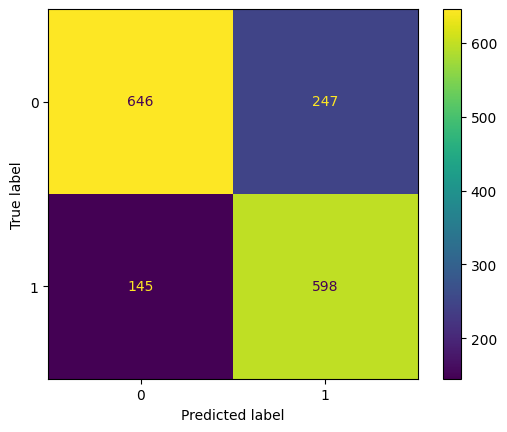

In [138]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(sentiment_preds, tweet_labels)
ConfusionMatrixDisplay(cm).plot()